# dependencies

In [1]:
!pip install transformers datasets sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.2 MB/s eta 0:00:00


In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00


# load model

In [16]:
from transformers import MarianMTModel, MarianTokenizer

model_name = "Helsinki-NLP/opus-mt-ar-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


# load dataset

In [4]:
import urllib.request
import zipfile
import os

# Step 1: Download the ZIP file
url = "https://object.pouta.csc.fi/OPUS-GlobalVoices/v2018q4/moses/ar-en.txt.zip"
output_zip = "GlobalVoices.ar-en.zip"
urllib.request.urlretrieve(url, output_zip)

('GlobalVoices.ar-en.zip', <http.client.HTTPMessage at 0x7bff0147d5d0>)

In [5]:
# Step 2: Extract the ZIP file
extract_folder = "GlobalVoices_data"
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [6]:
# Step 3: Read the Arabic and English files
ar_path = os.path.join(extract_folder, "GlobalVoices.ar-en.ar")
en_path = os.path.join(extract_folder, "GlobalVoices.ar-en.en")

with open(ar_path, encoding='utf-8') as ar_file, \
     open(en_path, encoding='utf-8') as en_file:
    ar_sentences = [line.strip() for line in ar_file.readlines()]
    en_sentences = [line.strip() for line in en_file.readlines()]

In [7]:
# Step 4: Check a sample
print(f"Loaded {len(ar_sentences)} sentence pairs")
print("Example:")
print("AR:", ar_sentences[10])
print("EN:", en_sentences[10])

Loaded 63071 sentence pairs
Example:
AR: من المهم جداً في وقت يتم إنكار حرية التعبير لأصوات دولية عديدة من قبل حكوماتها وفي الولايات المتحدة، تسيطر كتلة إعلامية من العالم الأول من قلة متحدثة بالإنجليزية وتحدد ملكية، وتوزيع، ومحتوى الأخبار.
EN: It's so important at a time when so many international voices are denied free speech by their governments and, in the United States, a very few, English-speaking, first-world media conglomerates dominate and determine the ownership, distribution and content of news.


# preprocessing

## cleaning

In [8]:
import re

# Step 1: Align and filter sentence pairs
cleaned_ar = []
cleaned_en = []

removed_pairs = []

MIN_LEN = 3

for ar, en in zip(ar_sentences, en_sentences):
    original_ar = ar.strip()
    original_en = en.strip()

    # Skip empty or very short lines
    if len(original_ar) < MIN_LEN or len(original_en) < MIN_LEN:
        removed_pairs.append((original_ar, original_en, "too_short"))
        continue

    # Filter out garbage (long numbers)
    if re.search(r'\d{7,}', original_ar) or re.search(r'\d{7,}', original_en):
        removed_pairs.append((original_ar, original_en, "long_number"))
        continue

    # Filter out unwanted symbols
    if re.search(r'[\[\]{}@<>^*_=~]', original_ar) or re.search(r'[\[\]{}@<>^*_=~]', original_en):
        removed_pairs.append((original_ar, original_en, "noisy_symbols"))
        continue

    # If passed all checks, keep the pair
    cleaned_ar.append(original_ar)
    cleaned_en.append(original_en)

# Step 2: Report stats
print(f"Cleaned pairs: {len(cleaned_ar)}")
print(f"Removed pairs: {len(removed_pairs)}")

# Step 2: Report stats
print("Example cleaned pair:")
print("AR:", cleaned_ar[555])
print("EN:", cleaned_en[555])


Cleaned pairs: 56078
Removed pairs: 6993
Example cleaned pair:
AR: يوجد في ماليه وهي جزيرة صغيرة تبلغ من الحجم كيلومترين حوالي 30,000 من العماله الوافده, معظمهم من بلدان الجوار كسريلانكا والهند وبانغلادش.
EN: Malé, which is a small island of about two square kilometers, has a population of over 30,000 migrant workers. Most of them come from the neighbouring countries of Sri Lanka, India and Bangladesh.


In [9]:
# Dictionary to store the first example of each reason
seen_reasons = {}

for ar, en, reason in removed_pairs:
    if reason not in seen_reasons:
        seen_reasons[reason] = (ar, en)

# Print one example for each removal reason
print("🔍 One example per removal reason:\n")
for reason, (ar, en) in seen_reasons.items():
    print(f"[Reason: {reason}]")
    print("AR:", ar)
    print("EN:", en)
    print()


🔍 One example per removal reason:

[Reason: too_short]
AR: 
EN: 

[Reason: noisy_symbols]
AR: <a href="https://advocacy.
EN: Show your support by posting this badge on your blog!

[Reason: long_number]
AR: وكان المقال عن المحادثات التي جرت ضمن مجموعة فيسبوك، والتي حدثت بتكرار هنا: www. facebook.
EN: It was a topic of a conversation in a Facebook group, which originally occurred here: www.facebook.com/topic.php?uid=2204704082&topic=6904 (as you can see in the screencap)



## split the data

In [10]:
from sklearn.model_selection import train_test_split

# Step 1: Create tuples for easier shuffling/splitting
sentence_pairs = list(zip(cleaned_ar, cleaned_en))

# Step 2: Train (80%) and temp (20%)
train_pairs, temp_pairs = train_test_split(sentence_pairs, test_size=0.2, random_state=42)

# Step 3: From temp, get val (10%) and test (10%)
val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

# Step 4: Separate into AR/EN again
train_ar, train_en = zip(*train_pairs)
val_ar, val_en = zip(*val_pairs)
test_ar, test_en = zip(*test_pairs)

print(f"Train size: {len(train_ar)}")
print(f"Val size: {len(val_ar)}")
print(f"Test size: {len(test_ar)}")


Train size: 44862
Val size: 5608
Test size: 5608


## tokeizaiton

In [ ]:
# See max token lengths for Arabic and English
ar_lengths = [len(tokenizer.tokenize(sent)) for sent in cleaned_ar]
en_lengths = [len(tokenizer.tokenize(sent)) for sent in cleaned_en]

print("Max Arabic tokens:", max(ar_lengths))
print("Max English tokens:", max(en_lengths))


Max Arabic tokens: 412
Max English tokens: 452


In [ ]:
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(self, ar_sentences, en_sentences, tokenizer, max_length=256):
        self.tokenizer = tokenizer
        self.ar = ar_sentences
        self.en = en_sentences
        self.max_length = max_length

    def __len__(self):
        return len(self.ar)

    def __getitem__(self, idx):
        source = self.ar[idx]
        target = self.en[idx]

        # Tokenize source and target
        model_inputs = self.tokenizer(source, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt")
        with self.tokenizer.as_target_tokenizer():
            labels = self.tokenizer(target, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt")

        # Remove batch dimension
        model_inputs = {k: v.squeeze() for k, v in model_inputs.items()}
        model_inputs["labels"] = labels["input_ids"].squeeze()
        return model_inputs

# Create dataset objects
train_dataset = TranslationDataset(train_ar, train_en, tokenizer)
val_dataset = TranslationDataset(val_ar, val_en, tokenizer)

# training

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./marian-ar-en-finetuned",  # where model checkpoints will be saved
    save_strategy="epoch",                  # save at the end of every epoch
    logging_strategy="epoch",               # log at the end of every epoch
    per_device_train_batch_size=32,         # adjust based on your GPU/Colab memory
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    num_train_epochs=3,
    save_total_limit=2,                     # keep only the 2 most recent checkpoints
    predict_with_generate=True,             # needed for translation models
    fp16=True,                              # enable mixed precision (faster on GPU)
    report_to="none"                        # disable wandb/huggingface logging
)


In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

<ipython-input-14-e0bfea3f5dad>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Step,Training Loss
1402,0.373100
2804,0.232200
4206,0.219700


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62833]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argume

TrainOutput(global_step=4206, training_loss=0.2750276356042707, metrics={'train_runtime': 2212.6787, 'train_samples_per_second': 60.825, 'train_steps_per_second': 1.901, 'total_flos': 9124490684399616.0, 'train_loss': 0.2750276356042707, 'epoch': 3.0})

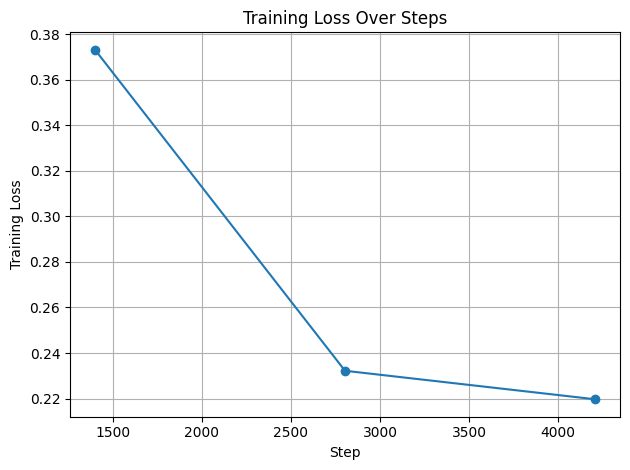

In [ ]:
import matplotlib.pyplot as plt

# Data
steps = [1402, 2804, 4206]
loss = [0.3731, 0.2322, 0.2197]

# Plot
plt.plot(steps, loss, marker='o')
plt.title('Training Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'eval_loss': 0.2334008663892746,
 'eval_runtime': 39.855,
 'eval_samples_per_second': 140.71,
 'eval_steps_per_second': 4.416,
 'epoch': 3.0}

# downloading the model and checkpoints


In [ ]:
import shutil

# Path to your fine-tuned model folder
folder_path = "./marian-ar-en-finetuned"
zip_path = folder_path + ".zip"

# Create a zip file
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)


'/content/marian-ar-en-finetuned.zip'

In [ ]:
from google.colab import files

# Download the zip file
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
trainer.save_model("translation_model1")

In [ ]:
!zip -r translation_model1.zip translation_model1

  adding: translation_model1/ (stored 0%)
  adding: translation_model1/generation_config.json (deflated 43%)
  adding: translation_model1/config.json (deflated 62%)
  adding: translation_model1/special_tokens_map.json (deflated 35%)
  adding: translation_model1/vocab.json (deflated 77%)
  adding: translation_model1/training_args.bin (deflated 51%)
  adding: translation_model1/target.spm (deflated 49%)
  adding: translation_model1/model.safetensors (deflated 7%)
  adding: translation_model1/tokenizer_config.json (deflated 68%)
  adding: translation_model1/source.spm (deflated 55%)


In [ ]:
from google.colab import files
files.download("translation_model1.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

# Replace these paths
source_folder = '/content/translation_model'
destination = '/content/drive/MyDrive/Translation_model'

shutil.copytree(source_folder, destination)


'/content/drive/MyDrive/Translation_model'

# testing the model

In [ ]:
import zipfile
import os

# Path to your uploaded zip file
zip_path = "/content/translation_model1.zip"
extract_path = "/content/translation_model"  # Folder to extract to

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Model unzipped successfully!")


✅ Model unzipped successfully!


In [21]:
from transformers import MarianMTModel, MarianTokenizer

model_path = "/content/drive/MyDrive/Translation_model/translation_model1" # Updated path

tokenizer = MarianTokenizer.from_pretrained(model_path)
model = MarianMTModel.from_pretrained(model_path)

In [ ]:
import evaluate
import torch

# Load BLEU evaluator
bleu = evaluate.load("sacrebleu")

# Set model to eval mode
model.eval()

# Select the first 10 sentences
batch_ar = test_ar[:10]
batch_en = test_en[:10]

# Tokenize the input
inputs = tokenizer(batch_ar, return_tensors="pt", padding=True, truncation=True, max_length=256).to(model.device)

# Generate translations
with torch.no_grad():
    translated = model.generate(**inputs, max_length=256, num_beams=4)

# Decode predictions
decoded = tokenizer.batch_decode(translated, skip_special_tokens=True)

# Prepare for BLEU
predictions = decoded
references = [[ref] for ref in batch_en]

# Compute BLEU score
results = bleu.compute(predictions=predictions, references=references)

# Print each sentence result
for i in range(10):
    print(f"\nSentence {i+1}:")
    print("🔸 Arabic:   ", batch_ar[i])
    print("🔹 Reference:", batch_en[i])
    print("✅ Predicted:", decoded[i])

# Print overall BLEU score
print("\n🌍 BLEU score on first 10 sentences:", results["score"])



Sentence 1:
🔸 Arabic:    نشر الأستاذ الجامعي لمادة التاريخ Yi-Fen Hua في مدونته شارحًا لماذا يعتقد بأن المبادىء التوجيهية الجديدة للكتاب المدرسي محكوم عليها بالفشل.
🔹 Reference: History professor Yi-Fen Hua explained in a blog post why the new textbook guidelines are doomed to fail:
✅ Predicted: Yai-Fen Hua published in his blog explaining why he thinks the new guidelines for the school book are doomed to failure.

Sentence 2:
🔸 Arabic:    قُبض عليه في 4 يونيو / حزيران 2000 وبعد سنة حكمت عليه محكمة في تونس بعامين سجنا لـ "نشره معلومات خاطئة" و"الاستعمال غير المرخص به لشبكة الإنترنت" و"سرقة رب عمل".
🔹 Reference: He was arrested on June, 4, 2000, and one year later, a court in Tunis sentenced him to two years in prison for "publishing false information", "non-authorized use of an Internet connection" and "theft from an employer."
✅ Predicted: He was arrested on June 4, 2000 and a year later, a Tunisian court sentenced him to two years in prison for "spreading false information", "unlice

In [22]:
import evaluate
import torch

# Load METEOR evaluator
meteor = evaluate.load("meteor")

# Set model to eval mode
model.eval()

# Select the first 10 sentences
batch_ar = test_ar[:10]
batch_en = test_en[:10]

# Tokenize the input
inputs = tokenizer(batch_ar, return_tensors="pt", padding=True, truncation=True, max_length=256).to(model.device)

# Generate translations
with torch.no_grad():
    translated = model.generate(**inputs, max_length=256, num_beams=4)

# Decode predictions
decoded = tokenizer.batch_decode(translated, skip_special_tokens=True)

# Prepare for METEOR
predictions = decoded
references = batch_en  # METEOR accepts plain lists, not nested lists

# Compute METEOR score
results = meteor.compute(predictions=predictions, references=references)

# Print each sentence result
for i in range(10):
    print(f"\nSentence {i+1}:")
    print("🔸 Arabic:   ", batch_ar[i])
    print("🔹 Reference:", batch_en[i])
    print("✅ Predicted:", decoded[i])

# Print overall METEOR score
print("\n🌍 METEOR score on first 10 sentences:", results["meteor"])


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...



Sentence 1:
🔸 Arabic:    نشر الأستاذ الجامعي لمادة التاريخ Yi-Fen Hua في مدونته شارحًا لماذا يعتقد بأن المبادىء التوجيهية الجديدة للكتاب المدرسي محكوم عليها بالفشل.
🔹 Reference: History professor Yi-Fen Hua explained in a blog post why the new textbook guidelines are doomed to fail:
✅ Predicted: Yai-Fen Hua published in his blog explaining why he thinks the new guidelines for the school book are doomed to failure.

Sentence 2:
🔸 Arabic:    قُبض عليه في 4 يونيو / حزيران 2000 وبعد سنة حكمت عليه محكمة في تونس بعامين سجنا لـ "نشره معلومات خاطئة" و"الاستعمال غير المرخص به لشبكة الإنترنت" و"سرقة رب عمل".
🔹 Reference: He was arrested on June, 4, 2000, and one year later, a court in Tunis sentenced him to two years in prison for "publishing false information", "non-authorized use of an Internet connection" and "theft from an employer."
✅ Predicted: He was arrested on June 4, 2000 and a year later, a Tunisian court sentenced him to two years in prison for "spreading false information", "unlice